# Point clouds

We cover in this tutorial the instantiation and use of a `PointCloud` geometry. 

A `PointCloud` geometry holds two arrays of vectors, endowed with a cost function. Such a geometry should cover most users' needs. 

We further show differentiation through optimal transport as an example of optimization that leverages first-order gradients.

This Notebook can be run on either Jupyter Notebook or Colab (which requires running `! pip install ott-jax` first).

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

## Creates a PointCloud geometry

In [2]:
def create_points(n, m, d):
  rng = jax.random.PRNGKey(0)
  rngs = jax.random.split(rng, 3)
  x = jax.random.normal(rngs[0], (n,d)) + 1
  y = jax.random.uniform(rngs[1], (m,d))
  a = jnp.ones((n,)) / n
  b = jnp.ones((m,)) / m
  return x, y, a, b

n, m, d = 12, 14, 2
x, y, a, b = create_points(n=n, m=m, d=d)

## Computes the regularized optimal transport

To compute the transport matrix between the two point clouds, one can define a `PointCloud` geometry (which by default uses `ott.geometry.costs.Euclidean` for cost function), then call the `sinkhorn` function, and build the transport matrix from the optimized potentials.

In [3]:
geom = pointcloud.PointCloud(x, y, epsilon=1e-2)
out = sinkhorn.sinkhorn(geom, a, b)
P = geom.transport_from_potentials(out.f, out.g)

A more concise syntax to compute the optimal transport matrix is to use the `Transport` interface. Note how weights are assumed to be uniform if no parameter `a` and `b` is passed to `Transport`. 

In [4]:
ot = transport.Transport(x, y, epsilon=1e-2)

## Visualizes the transport

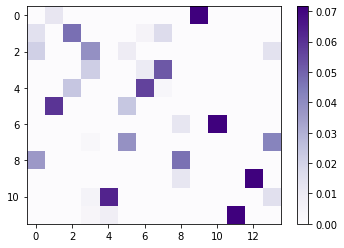

In [5]:
plt.imshow(ot.matrix, cmap='Purples')
plt.colorbar()

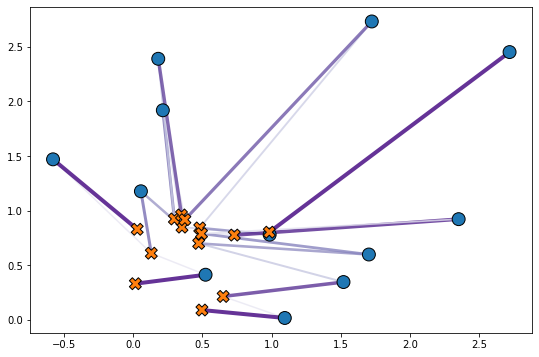

In [6]:
def plot_couplings(
    x, y, a, b, transport, 
    threshold=1e-2,
    plot_xlim=None, plot_ylim=None,
    save_fn=None, show_plot=True,
):
  fig = plt.figure(figsize=(9, 6))
  plt.scatter(*x.T, s=a*2000, edgecolors='k', marker='o', label='x')
  plt.scatter(*y.T, s=b*2000, edgecolors='k', marker='X', label='y')

  cmap = plt.get_cmap('Purples')
  u, v = jnp.where(transport > threshold)
  c = P[jnp.where(transport > threshold)]
  xy = jnp.concatenate([x[u], y[v]], axis=-1)
  for i in range(xy.shape[0]):
    strength = jnp.max(jnp.array(P.shape)) * c[i]
    plt.plot(xy[i, [0, 2]], xy[i, [1, 3]],
             linewidth=1 + strength*3,
             color=cmap(strength),
             zorder=0, alpha=0.8)
      
  if plot_xlim is not None:
    plt.xlim(plot_xlim)
  if plot_ylim is not None:
    plt.ylim(plot_ylim)
  if save_fn is not None:
    plt.savefig(save_fn, bbox_inches='tight')
  if show_plot:
    plt.show()
  else:
    plt.close(fig)

plot_couplings(x, y, ot.a, ot.b, ot.matrix) # It's the same as `plot_couplings(x, y, a, b, P)`

## Differentiation through Optimal Transport

Our Optimal transport is implemented in a differentiable way. In the following example, we leverage the gradients to move `a` points in a way that minimizes a given cost function, which can be customized.

In [7]:
import base64
import glob
import os
import shutil

from IPython import display

dot = ott.geometry.costs.dot

@jax.tree_util.register_pytree_node_class
class Cosine(ott.geometry.costs.CostFn):
  def pairwise(self, x, y):
    x_norm = jnp.linalg.norm(x, axis=-1)
    y_norm = jnp.linalg.norm(y, axis=-1)
    
    cosine_similarity = dot(x, y) / x_norm / y_norm
    cosine_distance = 1 - cosine_similarity
    return cosine_distance
    
cost_fn_map = {
  'Euclidean': ott.geometry.costs.Euclidean,
  'Cosine': Cosine,
}

def _infer_plot_lim(v):
  min_, max_ = v.min(), v.max()
  diff = max_ - min_
  margin = diff * 0.1
  return [min_-margin, max_+margin]
    
def infer_plot_xlim(x, y):
  v = jnp.concatenate([x[...,0], y[...,0]])
  return _infer_plot_lim(v)

def infer_plot_ylim(x, y):
  v = jnp.concatenate([x[...,1], y[...,1]])
  return _infer_plot_lim(v)

def prepare_out(out):
  os.makedirs(out, exist_ok=True)
  shutil.rmtree(out, ignore_errors=True)
  os.makedirs(out, exist_ok=True)

def optimize(n, m, d, cost_fn_name, n_iterations=100+1):
  n_report_iterations = 50
  n_save_iterations = 10
  learning_rate = 0.2

  x, y, a, b = create_points(n=n, m=m, d=d)

  cost_fn = cost_fn_map[cost_fn_name]()

  geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, epsilon=1e-2)
  out = sinkhorn.sinkhorn(geom, a, b)
  P = geom.transport_from_potentials(out.f, out.g)
  
  reg_ot_cost_vg = jax.value_and_grad(
    (lambda *args, **kwargs: sinkhorn.sinkhorn(*args, **kwargs).reg_ot_cost), 
    argnums=0,
  )

  plot_xlim = infer_plot_xlim(x, y)
  plot_ylim = infer_plot_ylim(x, y)

  out_dir = f'out/n={n}-m={m}-d={d}-cost_fn_name={cost_fn_name}'
  print(f'Resutls are saved to {out_dir}')
  prepare_out(out_dir)

  for iter_ in range(0, n_iterations):
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, epsilon=1e-2)
    out = sinkhorn.sinkhorn(geom, a, b)
    P = geom.transport_from_potentials(out.f, out.g)
    reg_ot_cost, geom_g = reg_ot_cost_vg(geom, a, b)

    if iter_ % n_report_iterations == 0 or iter_ == n_iterations - 1:
      print(f'iter_={iter_:3d},  reg_ot_cost={reg_ot_cost:.6f}, ')
    if iter_ % n_save_iterations == 0 or iter_ == n_iterations - 1:
      plot_couplings(x, y, a, b, P, threshold=1e-3, 
                     save_fn=f'{out_dir}/plot_iter_{iter_:08d}.png',
                     plot_xlim=plot_xlim, plot_ylim=plot_ylim, show_plot=False)
      plt.close()

    x = x - geom_g.x * learning_rate

  return out_dir

def animate(out_dir):
  prefix = 'plot'
  fns = glob.glob(f'{out_dir}/{prefix}_iter*.png')
  fns.sort()
  imgs = [Image.open(_) for _ in fns]
  gif_fn = f'{out_dir}/{prefix}.gif'
  imgs[0].save(gif_fn, save_all=True, append_images=imgs[1:], duration=250, 
               loop=0)
  print(f'Animation is saved to {gif_fn}')
  return gif_fn

def show_gif(gif_fn):
  with open(gif_fn, 'rb') as f:
    base64_encode = base64.b64encode(f.read()).decode('ascii') 
  return display.HTML(f'<img src="data:image/gif;base64,{base64_encode}" />')


Resutls are saved to out/n=12-m=14-d=2-cost_fn_name=Euclidean
iter_=  0,  reg_ot_cost=1.806588, 
iter_= 50,  reg_ot_cost=0.090033, 
iter_=100,  reg_ot_cost=0.031363, 
Animation is saved to out/n=12-m=14-d=2-cost_fn_name=Euclidean/plot.gif



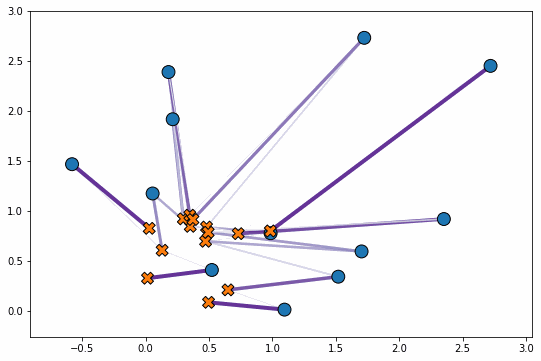

In [8]:
out_dir = optimize(12, 14 , 2, "Euclidean", 100+1)
gif_fn = animate(out_dir)
show_gif(gif_fn)

We could use another cost function, in this case Cosine distance, to achieve another kind of  dynamics in optimization.

Resutls are saved to out/n=12-m=14-d=2-cost_fn_name=Cosine
iter_=  0,  reg_ot_cost=0.068768, 
iter_= 50,  reg_ot_cost=0.043435, 
iter_=100,  reg_ot_cost=0.033790, 
iter_=150,  reg_ot_cost=0.028240, 
iter_=200,  reg_ot_cost=0.024760, 
Animation is saved to out/n=12-m=14-d=2-cost_fn_name=Cosine/plot.gif



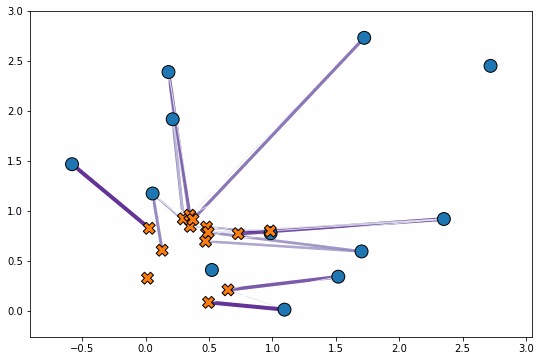

In [9]:
out_dir = optimize(12, 14 , 2, "Cosine", 200+1)
gif_fn = animate(out_dir)
show_gif(gif_fn)